# Parallel graph traversal

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

from collections import deque

## Snapping chains

Suppose there is a template chain and a data chain. The data chain contains all of the vertices in the template chain. The problem is to marry up the data chain vertex with the right template chain vertex.

In [2]:
class TemplateChainVertex:
    """Vertex in the template chain."""
    def __init__(self, name):
        self.name = name
        self.child = None
        self.parent = None
    def __repr__(self):
        return f"TemplateChainVertex({self.name})"

In [3]:
class DataChainVertex:
    """Vertex in the data."""
    def __init__(self, name, identifier):
        self.name = name
        self.identifier = identifier
        self.child = None
        self.parent = None
    def __repr__(self):
        return f"DataChainVertex({self.name}, {self.identifier})"    

In [4]:
def build_template_chain(spec):
    """Build a list of template vertices from its string representation."""
    assert isinstance(spec, str)
    
    names = spec.split(" -> ")
    vertices = [TemplateChainVertex(n) for n in names]    
    
    for i in range(0, len(names)-1):
        vertices[i].child = vertices[i+1]
        vertices[i+1].parent = vertices[i]
    
    return vertices

In [5]:
def draw_template_chain(vertices):
    """Plot the template chain."""
    G = nx.DiGraph()
       
    for v in vertices:
        if v.child is not None:
            G.add_edge(v.name, v.child.name)

    nx.draw(G, node_color='blue', with_labels=True, font_weight='bold')

In [6]:
def build_data_chain(spec):
    """Build a list of data vertices from its string representation."""    
    assert isinstance(spec, str)
    
    names = spec.split(" -> ")
    vertices = []
    for n in names:
        name, identifier = n.split(":")
        vertices.append(DataChainVertex(name, identifier))
    
    for i in range(0, len(names)-1):
        vertices[i].child = vertices[i+1]
        vertices[i+1].parent = vertices[i]
    
    return vertices

In [7]:
def draw_data_chain(vertices):
    """Plot the data chain."""
    G = nx.DiGraph()
       
    for v in vertices:
        if v.child is not None:
            src = f"{v.name}:{v.identifier}"
            dst = f"{v.child.name}:{v.child.identifier}"
            G.add_edge(src, dst)

    nx.draw(G, node_color='red', with_labels=True, font_weight='bold')

In [8]:
template_chain = "a -> b -> c -> d -> e"
data_chain = "a:1 -> b:2 -> c:3 -> d:4 -> e:5"

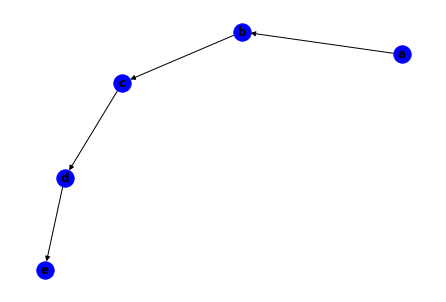

In [9]:
template_vertices = build_template_chain(template_chain)
draw_template_chain(template_vertices)

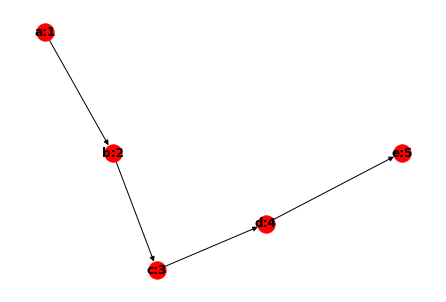

In [10]:
data_vertices = build_data_chain(data_chain)
draw_data_chain(data_vertices)

In [11]:
def find_root(vertices):
    """Find the root vertex, i.e. the vertex with no parents."""
    roots = []
    for v in vertices:
        if v.parent is None:
            roots.append(v)
    
    assert len(roots) == 1
    return roots[0]

In [12]:
def snap_vertices_in_chain(template_vertices, data_vertices):
    
    root_template_vertex = find_root(template_vertices)
    root_data_vertex = find_root(data_vertices)
    
    pairs = []
    
    if root_template_vertex.name != root_data_vertex.name:
        return [], "Different roots"

    pairs.append((root_template_vertex, root_data_vertex))
    current_template = pairs[-1][0]
    current_data = pairs[-1][1]
    
    while current_template.child is not None:
        
        if current_template.child.name == current_data.child.name:
            pairs.append((current_template.child, current_data.child))
        else:
            return [], "Child doesn't match template"
        
        current_template = pairs[-1][0]
        current_data = pairs[-1][1]
    
    return pairs, ""

In [13]:
def plot_snapped(vertex_pairs, template_colour='red', data_colour='green'):
    
    G = nx.DiGraph()
    
    if len(vertex_pairs) == 0:
        return
    
    def template_string(vertex):
        return f"{vertex.name}"
    
    def data_string(vertex):
        return f"{vertex.name}:{vertex.identifier}"
    
    template_vertex = vertex_pairs[0][0]
    data_vertex = vertex_pairs[0][1]
    
    G.add_node(template_string(template_vertex), color=template_colour)
    G.add_node(data_string(data_vertex), color=data_colour)
    G.add_edge(template_string(template_vertex), data_string(data_vertex), color="grey")
    
    while template_vertex.child is not None:
        
        template_vertex = template_vertex.child
        data_vertex = data_vertex.child
        
        G.add_node(template_string(template_vertex), color=template_colour)
        G.add_node(data_string(data_vertex), color=data_colour)
        G.add_edge(template_string(template_vertex), data_string(data_vertex), color="grey")
        
        # Connect to parents
        G.add_edge(template_string(template_vertex.parent), template_string(template_vertex), color="purple")
        G.add_edge(data_string(data_vertex.parent), data_string(data_vertex), color="purple")
    
    # Get the node colours
    node_colors = [node[1]['color'] for node in G.nodes(data=True)]

    edge_colors = nx.get_edge_attributes(G,'color').values()

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, edge_color=edge_colors)    

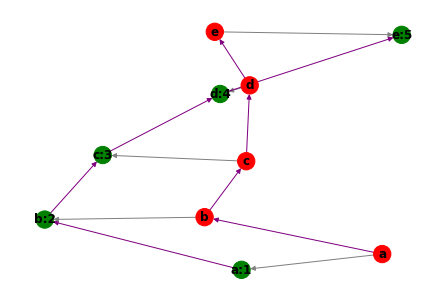

In [14]:
snapped, msg = snap_vertices_in_chain(template_vertices, data_vertices)
plot_snapped(snapped)

## Snapping a partial chain to a full chain

In the algorithm above, the data chain had to contain all of the vertices in the template. In this section that requirement is softened such that the data chain can partially contain the vertices in the template.

In [15]:
template_chain = "a -> b -> c -> d -> e"
data_chain = "b:2 -> c:3"

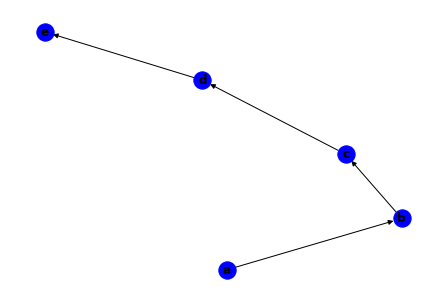

In [16]:
template_vertices = build_template_chain(template_chain)
draw_template_chain(template_vertices)

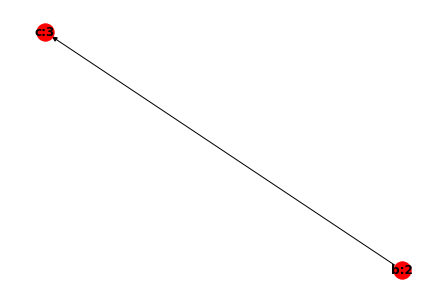

In [17]:
data_vertices = build_data_chain(data_chain)
draw_data_chain(data_vertices)

In [18]:
def snap_vertices_in_partial_chain(template_vertices, data_vertices):
    
    root_template_vertex = find_root(template_vertices)
    root_data_vertex = find_root(data_vertices)
    
    pairs = []
    
    current_template = root_template_vertex
    current_data = root_data_vertex
    data_state = "not started"
    
    template_finished = False
    
    while not template_finished:
        
        #print(f"Processing {current_template} and {current_data} / {data_state}")
        
        matched_data = None
        
        if data_state == "not started" and current_template.name == current_data.name:
            data_state = "in progress"
            matched_data = current_data
            
        elif data_state == "in progress":
            if current_template.name == current_data.name:
                matched_data = current_data
            else:
                return [], f"Unexpected data vertex {current_data} for template {current_template}"
        
        pairs.append((current_template, matched_data))
        
        if data_state == "in progress":
            if current_data.child is None:
                data_state = "finished"
            else:
                current_data = current_data.child
        
        if current_template.child is None:
            template_finished = True
        else:
            current_template = current_template.child
            
    return pairs, ""

In [19]:
vertex_pairs, msg = snap_vertices_in_partial_chain(template_vertices, data_vertices)
vertex_pairs

[(TemplateChainVertex(a), None),
 (TemplateChainVertex(b), DataChainVertex(b, 2)),
 (TemplateChainVertex(c), DataChainVertex(c, 3)),
 (TemplateChainVertex(d), None),
 (TemplateChainVertex(e), None)]

In [20]:
def plot_snapped_partial(vertex_pairs, template_colour='red', data_colour='green'):
    
    G = nx.DiGraph()
    
    if len(vertex_pairs) == 0:
        return
    
    def template_string(vertex):
        return f"{vertex.name}"
    
    def data_string(vertex):
        return f"{vertex.name}:{vertex.identifier}"
        
    for p in vertex_pairs:
        
        template_vertex = p[0]
        data_vertex = p[1]
        
        G.add_node(template_string(template_vertex), color=template_colour)
        
        if data_vertex is not None:
            G.add_node(data_string(data_vertex), color=data_colour)
            G.add_edge(template_string(template_vertex), data_string(data_vertex), color="grey")
            
            if data_vertex.parent is not None:
                G.add_edge(data_string(data_vertex.parent), data_string(data_vertex), color="purple")
        
        if template_vertex.parent is not None:
            G.add_edge(template_string(template_vertex.parent), template_string(template_vertex), color="purple")
    
    # Get the node colours
    node_colors = [node[1]['color'] for node in G.nodes(data=True)]

    edge_colors = nx.get_edge_attributes(G,'color').values()

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, edge_color=edge_colors)    

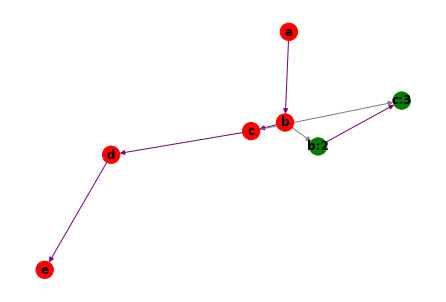

In [21]:
plot_snapped_partial(vertex_pairs, template_colour='red', data_colour='green')

## Full chain, extra data vertex insertions

In this case the data chain will be complete, but an extra vertex must be inserted when a particular data vertex is found.

In [22]:
template_chain = "a -> b -> c -> d -> e"
data_chain = "a:1 -> b:2 -> c:3 -> d:4 -> e:5"

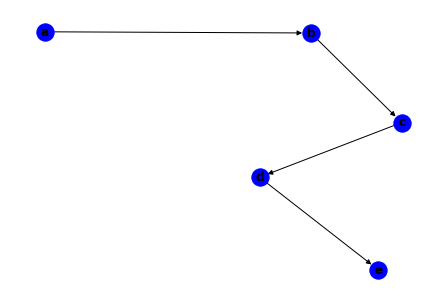

In [23]:
template_vertices = build_template_chain(template_chain)
draw_template_chain(template_vertices)

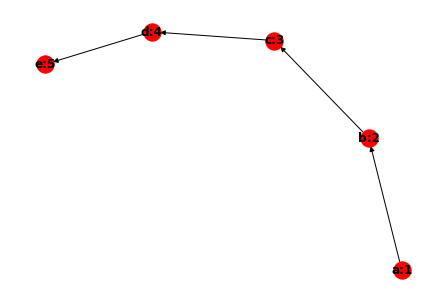

In [24]:
data_vertices = build_data_chain(data_chain)
draw_data_chain(data_vertices)

In [25]:
def snap_vertices_in_chain_extended(template_vertices, data_vertices, insertion_ids):
    
    current_template = find_root(template_vertices)
    current_data = find_root(data_vertices)
    
    pairs = []
    template_finished = False
    
    while not template_finished:
        
        print(f"Processing {current_template} and {current_data}")        
        
        if current_template.name == current_data.name:
            pairs.append((current_template, current_data))
        else:
            return [], "Child doesn't match template"
        
        if current_data.identifier in insertion_ids:
            new_child = DataChainVertex(current_data.name, "EXTRA")
            pairs.append((None, new_child))
        
        if current_template.child is not None:
            current_template = current_template.child
            current_data = current_data.child
        else:
            template_finished = True
    
    return pairs, ""

In [26]:
pairs, msg = snap_vertices_in_chain_extended(template_vertices, data_vertices, {"1", "2", "5"})
pairs

Processing TemplateChainVertex(a) and DataChainVertex(a, 1)
Processing TemplateChainVertex(b) and DataChainVertex(b, 2)
Processing TemplateChainVertex(c) and DataChainVertex(c, 3)
Processing TemplateChainVertex(d) and DataChainVertex(d, 4)
Processing TemplateChainVertex(e) and DataChainVertex(e, 5)


[(TemplateChainVertex(a), DataChainVertex(a, 1)),
 (None, DataChainVertex(a, EXTRA)),
 (TemplateChainVertex(b), DataChainVertex(b, 2)),
 (None, DataChainVertex(b, EXTRA)),
 (TemplateChainVertex(c), DataChainVertex(c, 3)),
 (TemplateChainVertex(d), DataChainVertex(d, 4)),
 (TemplateChainVertex(e), DataChainVertex(e, 5)),
 (None, DataChainVertex(e, EXTRA))]

## Partial chain, extra data vertex insertions

In [27]:
template_chain = "a -> b -> c -> d -> e"
data_chain = "b:2 -> c:3 -> d:4"

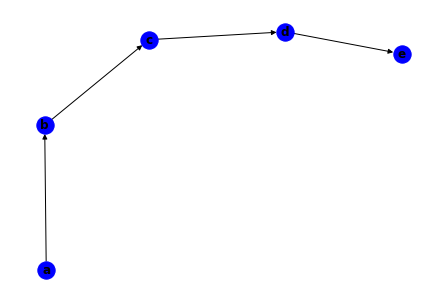

In [28]:
template_vertices = build_template_chain(template_chain)
draw_template_chain(template_vertices)

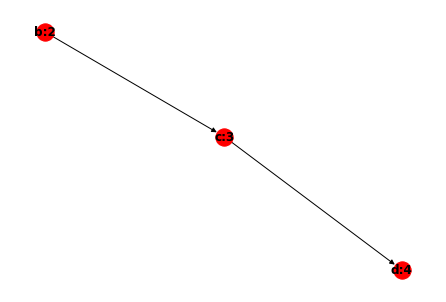

In [29]:
data_vertices = build_data_chain(data_chain)
draw_data_chain(data_vertices)

In [30]:
def snap_vertices_in_partial_chain_extended(template_vertices, data_vertices, insertion_ids):
    
    current_template = find_root(template_vertices)
    current_data = find_root(data_vertices)
    
    pairs = []
    data_state = "not started"
    
    template_finished = False
    
    while not template_finished:
        
        #print(f"Processing {current_template} and {current_data} / {data_state}")
        
        # Process the current vertex
        matched_data = None
        
        if data_state == "not started" and current_template.name == current_data.name:
            data_state = "in progress"
            matched_data = current_data
            
        elif data_state == "in progress":
            if current_template.name == current_data.name:
                matched_data = current_data
            else:
                return [], f"Unexpected data vertex {current_data} for template {current_template}"
        
        pairs.append((current_template, matched_data))
        
        # Does there need to be an insertion?
        if data_state == "in progress" and current_data.identifier in insertion_ids:
            new_child = DataChainVertex(current_data.name, "EXTRA")
            pairs.append((None, new_child))            
        
        # Move onto the next vertex
        if data_state == "in progress":
            if current_data.child is None:
                data_state = "finished"
            else:
                current_data = current_data.child
        
        if current_template.child is None:
            template_finished = True
        else:
            current_template = current_template.child
            
    return pairs, ""

In [31]:
snap_vertices_in_partial_chain_extended(template_vertices, data_vertices, {"2"})

([(TemplateChainVertex(a), None),
  (TemplateChainVertex(b), DataChainVertex(b, 2)),
  (None, DataChainVertex(b, EXTRA)),
  (TemplateChainVertex(c), DataChainVertex(c, 3)),
  (TemplateChainVertex(d), DataChainVertex(d, 4)),
  (TemplateChainVertex(e), None)],
 '')

## Graph mutation

In [32]:
class Vertex:
    def __init__(self, name, identifier=0):
        self.name = name
        self.identifier = identifier
        self.children = []
        self.parents = []
        self.explored = False
    def __repr__(self):
        return f"Vertex({self.name}, {self.identifier})"

In [33]:
def find_vertex(vertices, name):
    for v in vertices:
        if v.name == name:
            return v
    return None

In [34]:
def build_graph(spec):
    """Build the graph from a list of edges."""
    assert isinstance(spec, str)
    
    vertices = []
    
    for link in spec.strip().split("\n"):
        
        src, dst = link.split(" -> ")
        
        src_vertex = find_vertex(vertices, src)
        if src_vertex is None:
            src_vertex = Vertex(src)
            vertices.append(src_vertex)
        
        dst_vertex = find_vertex(vertices, dst)
        if dst_vertex is None:
            dst_vertex = Vertex(dst)
            vertices.append(dst_vertex)
        
        src_vertex.children.append(dst_vertex)
        dst_vertex.parents.append(src_vertex)
    
    return vertices

In [35]:
edges = """
a -> c
b -> c
"""

In [36]:
vertices = build_graph(edges)
vertices

[Vertex(a, 0), Vertex(c, 0), Vertex(b, 0)]

In [37]:
def draw_network(vertices):
    G = nx.DiGraph()
       
    for v in vertices:
        if len(v.children) > 0:
            for c in v.children:
                src = f"{v.name}:{v.identifier}"
                dst = f"{c.name}:{c.identifier}"
                G.add_edge(src, dst)
        else:
            G.add_node(f"{v.name}:{v.identifier}")

    nx.draw(G, with_labels=True, font_weight='bold')

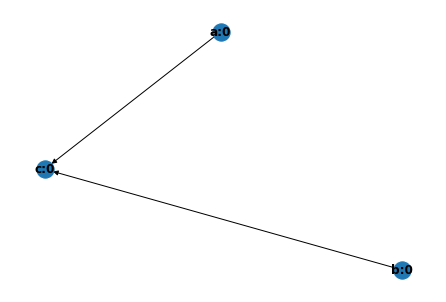

In [38]:
draw_network(vertices)

### Copy the entire graph

In [39]:
def copy_graph(initial_vertex, new_identifier=1):
    """Make an exact copy of the entire of a graph."""
    
    # Set of explored vertices
    explored = set()

    q = deque()
    q.append(initial_vertex)
    
    # Dict of a new vertex's name to the vertex object
    new_vertex_name_to_vertex = {}
    
    # Make all of the new (unconnected) vertices
    while len(q) > 0:
        
        # Take a vertex from the queue
        vertex = q.popleft()
    
        explored.add(vertex.name)
        print(f"Processing {vertex}")
        
        new_vertex = Vertex(vertex.name, new_identifier)
        print(f"Created {new_vertex}")
        new_vertex_name_to_vertex[vertex.name] = new_vertex

        for parent in vertex.parents:
            if not parent.name in explored:
                parent.explored = True
                q.append(parent)
        
        for child in vertex.children:
            if not child.name in explored:
                child.explored = True
                q.append(child)
    
    # Now connect up the vertices
    explored = set()
    
    q = deque()
    q.append(initial_vertex)
    
    while len(q) > 0:
        
        # Take a vertex from the queue
        vertex = q.popleft()
    
        explored.add(vertex.name)
        print(f"Processing {vertex} to connect it up")
        
        for parent in vertex.parents:
            if not parent.name in explored:
                parent.explored = True
                
                p = new_vertex_name_to_vertex[parent.name]
                v = new_vertex_name_to_vertex[vertex.name]
                v.parents.append(p)
                p.children.append(v)
                
                q.append(parent)
        
        for child in vertex.children:
            if not child.name in explored:
                child.explored = True
                
                c = new_vertex_name_to_vertex[child.name]
                v = new_vertex_name_to_vertex[vertex.name]
                v.children.append(c)
                c.parents.append(v)
                
                q.append(child)        
    
    return new_vertex_name_to_vertex

In [40]:
edges = """
a -> c
b -> c
c -> d
"""

vertices = build_graph(edges)
copy = copy_graph(vertices[0])

Processing Vertex(a, 0)
Created Vertex(a, 1)
Processing Vertex(c, 0)
Created Vertex(c, 1)
Processing Vertex(b, 0)
Created Vertex(b, 1)
Processing Vertex(d, 0)
Created Vertex(d, 1)
Processing Vertex(a, 0) to connect it up
Processing Vertex(c, 0) to connect it up
Processing Vertex(b, 0) to connect it up
Processing Vertex(d, 0) to connect it up


In [41]:
for _, v in copy.items():
    print(f"{v.name} - {v.children} - {v.parents}")

a - [Vertex(c, 1)] - []
c - [Vertex(d, 1)] - [Vertex(a, 1), Vertex(b, 1)]
b - [Vertex(c, 1)] - []
d - [] - [Vertex(c, 1)]


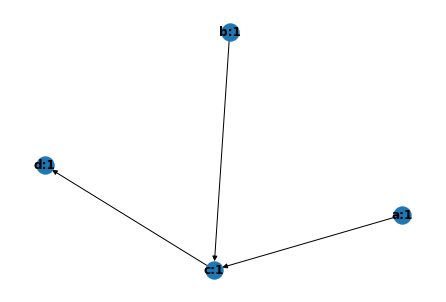

In [42]:
draw_network(list(copy.values()))

### Disconnect and reconnect a vertex

In [43]:
def find_vertex_by_name(vertex, name):
    """Find a vertex by name given a single vertex in a graph."""
    
    assert isinstance(vertex, Vertex), f"Expected a Vertex, got {type(vertex)}"
    
    q = deque()
    q.append(vertex)
    
    # Set of the names of explored vertices
    explored = set()
    
    while len(q) > 0:
        
        # Take a vertex from the queue
        vertex = q.popleft()
        
        # If the vertex has the required name, return it
        if vertex.name == name:
            return vertex
    
        explored.add(vertex.name)
        
        for p in vertex.parents:
            if not p.name in explored:
                p.explored = True
                q.append(p)
        
        for c in vertex.children:
            if not c.name in explored:
                c.explored = True
                q.append(c)
    
    # The vertex couldn't be found
    return None

In [44]:
find_vertex_by_name(vertices[0], 'd')

Vertex(d, 0)

In [45]:
def disconnect(vertex, name_of_vertex_to_disconnect):
    """Disconnect a vertex from the graph given any vertex in the graph."""
    
    # Find the vertex to disconnect
    vertex = find_vertex_by_name(vertex, name_of_vertex_to_disconnect)
    assert vertex is not None
    
    # Make a copy of the vertex's parents
    parents = vertex.parents[:]
    
    # Make a copy of the vertex's children
    children = vertex.children[:]
    
    # Disconnect the vertex <- parent connections
    vertex.parents = []
    
    for p in parents:
        p.children.remove(vertex)
    
    # Disconnect the vertex -> children connections
    vertex.children = []
    
    for c in children:
        c.parents.remove(vertex)
    
    # Return the parent and child vertices that were disconnected
    return vertex, parents, children

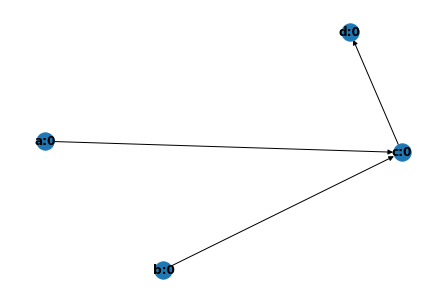

In [46]:
edges = """
a -> c
b -> c
c -> d
"""

vertices = build_graph(edges)
draw_network(vertices)

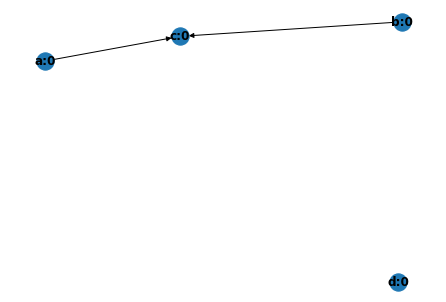

In [47]:
disconnected_vertex, parents, children = disconnect(vertices[0], 'd')
draw_network(vertices)

In [48]:
def reconnect(disconnected_vertex, parents, children):
    """Reconnect a vertex in the graph."""
    
    assert isinstance(disconnected_vertex, Vertex)
    assert isinstance(parents, list)
    assert isinstance(children, list)
    
    assert disconnected_vertex.parents == []
    assert disconnected_vertex.children == []
    
    # Reconnect the parents
    disconnected_vertex.parents = parents
    
    for p in parents:
        p.children.append(disconnected_vertex)
    
    # Reconnect the children
    disconnected_vertex.children = children
    
    for c in children:
        c.parents.append(disconnected_vertex)

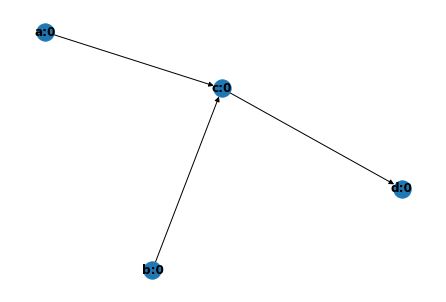

In [49]:
reconnect(disconnected_vertex, parents, children)
draw_network(vertices)

### Draw graph from a single vertex

In [50]:
def draw_network(vertices):
    G = nx.DiGraph()
       
    for v in vertices:
        if len(v.children) > 0:
            for c in v.children:
                src = f"{v.name}:{v.identifier}"
                dst = f"{c.name}:{c.identifier}"
                G.add_edge(src, dst)
        else:
            G.add_node(f"{v.name}:{v.identifier}")

    nx.draw(G, with_labels=True, font_weight='bold')

In [51]:
def draw_from_vertex(vertex):
    assert isinstance(vertex, Vertex), f"Expected a Vertex, got {type(vertex)}"
    
    G = nx.DiGraph()
    explored = set()
    
    q = deque()
    q.append(vertex)
    
    while len(q) > 0:
        
        # Take a vertex off the queue
        vertex = q.popleft()
        
        # Record that the vertex has been explored
        explored.add(vertex)
        
        if len(vertex.parents) == 0 and len(vertex.children) == 0:
            G.add_node(f"{vertex.name}:{vertex.identifier}")
    
        for p in vertex.parents:
            if not p in explored:
                explored.add(p)
                q.append(p)
                
                src = f"{p.name}:{p.identifier}"
                dst = f"{vertex.name}:{vertex.identifier}"
                G.add_edge(src, dst)
                
        
        for c in vertex.children:
            if not c in explored:
                explored.add(c)
                q.append(c)
                
                src = f"{vertex.name}:{vertex.identifier}"
                dst = f"{c.name}:{c.identifier}"  
                G.add_edge(src, dst)
    
    # Draw the graph
    nx.draw(G, with_labels=True, font_weight='bold')

### Disconnect a vertex and its parents

In [52]:
def disconnect_subgraph(vertex, name_of_vertex_to_disconnect):
    """Disconnect a vertex from the graph given any vertex in the graph."""
    
    # Find the vertex to disconnect
    vertex = find_vertex_by_name(vertex, name_of_vertex_to_disconnect)
    assert vertex is not None
    
    # Make a copy of the vertex's children
    children = vertex.children[:]

    # Disconnect the vertex's children
    for c in vertex.children:
        c.parents.remove(vertex)
        
    # Disconnect the vertex -> children connections
    vertex.children = []    
    
    # Return the child vertices that were disconnected
    return vertex, children

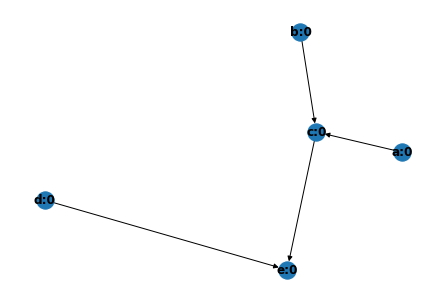

In [53]:
edges = """
a -> c
b -> c
c -> e
d -> e
"""

vertices = build_graph(edges)
draw_from_vertex(vertices[0])

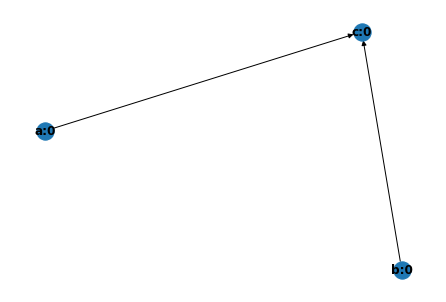

In [54]:
disconnected_vertex, children = disconnect_subgraph(vertices[0], 'c')
draw_from_vertex(disconnected_vertex)

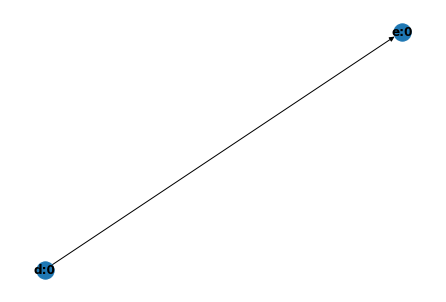

In [55]:
draw_from_vertex(vertices[-1])

In [56]:
def reconnect(disconnected_vertex, children):
    """Reconnect a vertex in the graph."""
    
    assert isinstance(disconnected_vertex, Vertex)
    assert isinstance(children, list)
    assert disconnected_vertex.children == []
    
    # Reconnect the children
    disconnected_vertex.children = children
    
    for c in children:
        c.parents.append(disconnected_vertex)

In [57]:
reconnect(disconnected_vertex, children)

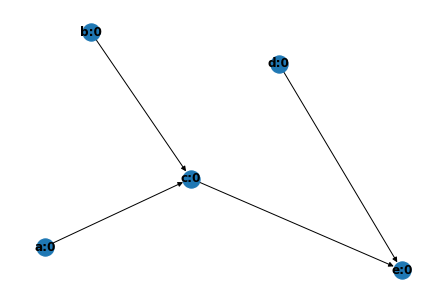

In [58]:
draw_from_vertex(vertices[-1])

### Copy part of the graph

In [59]:
def find_leaf_vertices(vertex):
    """Find the leaf vertices from a given vertex in the graph."""
    
    #assert isinstance(vertex, Vertex)
    
    q = deque()
    q.append(vertex)
    explored = set()
    leaf_vertices = []
    
    while len(q) > 0:

        vertex = q.popleft()
        explored.add(vertex)
        
        if len(vertex.children) == 0:
            leaf_vertices.append(vertex)
        
        for p in vertex.parents:
            if not p in explored:
                explored.add(p)
                q.append(p)
        
        for c in vertex.children:
            if not c in explored:
                explored.add(c)
                q.append(c)
        
    return leaf_vertices

In [60]:
def copy_part_of_graph(vertex, vertex_to_copy_from, n_copies=1):
    
    assert isinstance(vertex, Vertex)            # Any vertex in the graph
    assert isinstance(vertex_to_copy_from, str)  # Name of the vertex to copy from
    assert isinstance(n_copies, int) and n_copies > 0
    
    # Disconnect the vertex 
    disconnected_vertex, children = disconnect_subgraph(vertex, vertex_to_copy_from)
    assert len(children) == 1
    assert disconnected_vertex.children == []
    
    # Copy the vertices connected to the disconnected vertex
    copies = []
    for i in range(n_copies):
        copy = copy_graph(disconnected_vertex, i+1)
        copy = list(copy.values())[0]

        # Find the leaf vertex of the copied subgraph
        copy_leaves = find_leaf_vertices(copy)
        assert len(copy_leaves) == 1
        copies.append(copy_leaves[0])
    
    # Insert a new vertex
    new_vertex = Vertex("NEW", 0)
    new_vertex.parents = [disconnected_vertex]
    
    for copy in copies:
        new_vertex.parents.append(copy)
    
    new_vertex.children = [children[0]]
    children[0].parents.append(new_vertex)
    
    return new_vertex

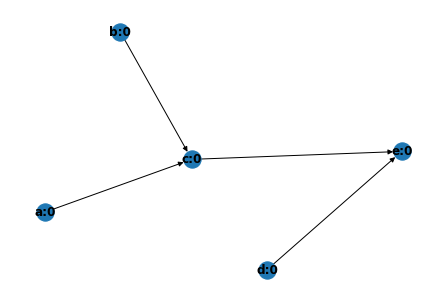

In [61]:
edges = """
a -> c
b -> c
c -> e
d -> e
"""

vertices = build_graph(edges)
draw_network(vertices)

Processing Vertex(c, 0)
Created Vertex(c, 1)
Processing Vertex(a, 0)
Created Vertex(a, 1)
Processing Vertex(b, 0)
Created Vertex(b, 1)
Processing Vertex(c, 0) to connect it up
Processing Vertex(a, 0) to connect it up
Processing Vertex(b, 0) to connect it up
Processing Vertex(c, 0)
Created Vertex(c, 2)
Processing Vertex(a, 0)
Created Vertex(a, 2)
Processing Vertex(b, 0)
Created Vertex(b, 2)
Processing Vertex(c, 0) to connect it up
Processing Vertex(a, 0) to connect it up
Processing Vertex(b, 0) to connect it up


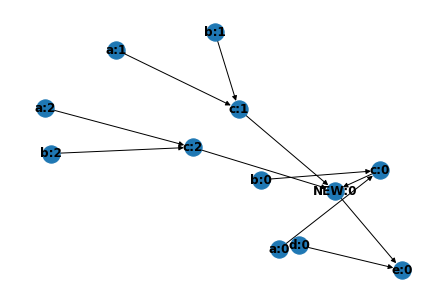

In [62]:
cpy = copy_part_of_graph(vertices[0], 'c', 2)
draw_from_vertex(cpy)

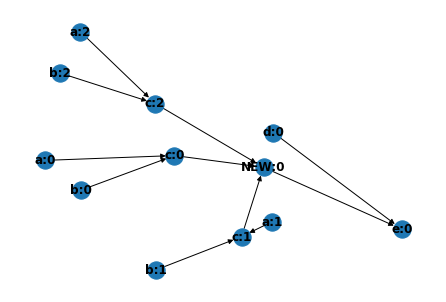

In [63]:
draw_from_vertex(cpy)

## Populate template from data

There is a template graph and a data graph. Both graphs have the same vertices and the same structure. The task is to take a field from the data graph and copy it to the template graph.

In [64]:
class TemplateVertex:
    def __init__(self, name):
        self.name = name
        self.identifier = None
        self.children = []
        self.parents = []
    def __repr__(self):
        return f"TemplateVertex({self.name}, {self.identifier})"    

In [65]:
class DataVertex:
    def __init__(self, name, identifier):
        self.name = name
        self.identifier = identifier
        self.children = []
        self.parents = []
    def __repr__(self):
        return f"DataVertex({self.name}, {self.identifier})"    

In [66]:
def find_template_vertex(vertices, name):
    for v in vertices:
        if v.name == name:
            return v
    return None

In [67]:
def find_data_vertex(vertices, name, identifier):
    for v in vertices:
        if v.name == name and v.identifier == identifier:
            return v
    return None

In [68]:
def build_template_graph(spec):
    """Build the template graph from a list of edges."""
    assert isinstance(spec, str)
    
    vertices = []
    
    for link in spec.strip().split("\n"):
        
        src, dst = link.split(" -> ")
        
        src_vertex = find_template_vertex(vertices, src)
        if src_vertex is None:
            src_vertex = TemplateVertex(src)
            vertices.append(src_vertex)
        
        dst_vertex = find_template_vertex(vertices, dst)
        if dst_vertex is None:
            dst_vertex = TemplateVertex(dst)
            vertices.append(dst_vertex)
        
        src_vertex.children.append(dst_vertex)
        dst_vertex.parents.append(src_vertex)
    
    return vertices

In [69]:
def build_data_graph(spec):
    """Build the template graph from a list of edges."""
    assert isinstance(spec, str)
    
    vertices = []
    
    for link in spec.strip().split("\n"):
        
        src, dst = link.split(" -> ")
        
        src_name, src_id = src.split(":")
        dst_name, dst_id = dst.split(":")
        
        src_vertex = find_data_vertex(vertices, src_name, src_id)
        if src_vertex is None:
            src_vertex = DataVertex(src_name, src_id)
            vertices.append(src_vertex)
        
        dst_vertex = find_data_vertex(vertices, dst_name, dst_id)
        if dst_vertex is None:
            dst_vertex = DataVertex(dst_name, dst_id)
            vertices.append(dst_vertex)
        
        src_vertex.children.append(dst_vertex)
        dst_vertex.parents.append(src_vertex)
    
    return vertices    

In [70]:
def draw_from_vertex(vertex):
    """Draw the graph given a single vertex within the graph."""
    
    assert isinstance(vertex, TemplateVertex) or isinstance(vertex, DataVertex) 
    
    G = nx.DiGraph()
    explored = set()
    
    q = deque()
    q.append(vertex)
    
    while len(q) > 0:
        
        # Take a vertex off the queue
        vertex = q.popleft()
        
        # Record that the vertex has been explored
        explored.add(vertex)
        
        if len(vertex.parents) == 0 and len(vertex.children) == 0:
            G.add_node(f"{vertex.name}:{vertex.identifier}")
    
        for p in vertex.parents:
            if not p in explored:
                explored.add(p)
                q.append(p)
                
                src = f"{p.name}:{p.identifier}"
                dst = f"{vertex.name}:{vertex.identifier}"
                G.add_edge(src, dst)
                
        
        for c in vertex.children:
            if not c in explored:
                explored.add(c)
                q.append(c)
                
                src = f"{vertex.name}:{vertex.identifier}"
                dst = f"{c.name}:{c.identifier}"  
                G.add_edge(src, dst)
    
    # Draw the graph
    nx.draw(G, with_labels=True, font_weight='bold')

In [71]:
template_edges = """
a -> b
b -> c
d -> c
"""

In [72]:
data_edges = """
a:1 -> b:2
b:2 -> c:3
d:4 -> c:3
"""

In [73]:
template_vertices = build_template_graph(template_edges)
data_vertices = build_data_graph(data_edges)

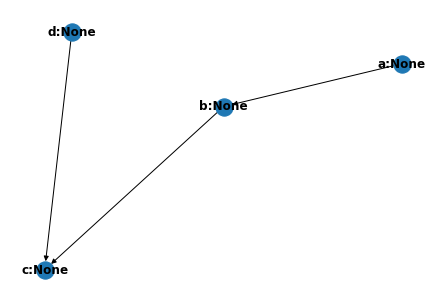

In [74]:
draw_from_vertex(template_vertices[0])

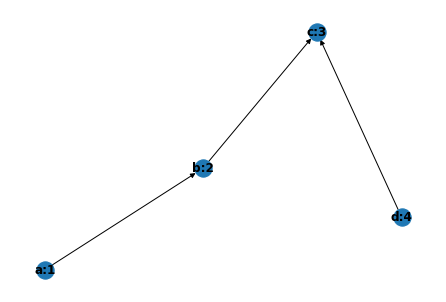

In [75]:
draw_from_vertex(data_vertices[0])

In [76]:
def find_data_vertices_by_name(data_vertex, name):
    
    assert isinstance(data_vertex, DataVertex)
    assert isinstance(name, str)
    
    vertices_with_name = []
    explored = set()
    
    q = deque()
    q.append(data_vertex)
    
    while len(q) > 0:
        
        vertex = q.popleft()
        explored.add(vertex)
        
        if vertex.name == name:
            vertices_with_name.append(vertex)
        
        for p in vertex.parents:
            if not p in explored:
                q.append(p)
                explored.add(p)
                
        for c in vertex.children:
            if not c in explored:
                q.append(c)
                explored.add(c)        
    
    return vertices_with_name

In [77]:
def vertex_with_name_in_list(vertices, name):
    for v in vertices:
        if v.name == name:
            return True
        
    return Fasle

In [78]:
def data_vertex_have_right_connections(template_vertex, data_vertex):
    """Does the data vertex contain the correct child and parent vertices?"""
    
    assert isinstance(template_vertex, TemplateVertex)
    assert isinstance(data_vertex, DataVertex)
    
    for c in data_vertex.children:
        if not vertex_with_name_in_list(template_vertex.children, c.name):
            return False
    
    for p in data_vertex.parents:
        if not vertex_with_name_in_list(template_vertex.parents, p.name):
            return False
        
    return True

In [79]:
def populate_template(template_vertex, data_vertex):
    
    assert isinstance(template_vertex, TemplateVertex)
    assert isinstance(data_vertex, DataVertex)
    
    # Find the leaf vertices
    template_leaves = find_leaf_vertices(template_vertex)
    assert len(template_leaves) == 1
    template_leaf = template_leaves[0]
    
    data_leaves = find_leaf_vertices(data_vertex)
    assert len(data_leaves) == 1
    data_leaf = data_leaves[0]
    
    print(f"Starting from {template_leaf} and {data_leaf}")
    
    q = deque()
    q.append(template_leaf)
    
    while len(q) > 0:
        
        template_vertex = q.popleft()
        print(f"Processing {template_vertex}")
        
        # Find the data vertices that match the template
        matching_data_vertices = find_data_vertices_by_name(data_vertex, template_vertex.name)
        assert len(matching_data_vertices) == 1
        
        # Check that the matching vertex has the right parents and children
        if not data_vertex_have_right_connections(template_vertex, matching_data_vertices[0]):
            print("Data vertex has incorrect relationships")
            return
        
        template_vertex.identifier = matching_data_vertices[0].identifier
        
        for p in template_vertex.parents:
            q.append(p)

In [80]:
populate_template(template_vertices[0], data_vertices[0])

Starting from TemplateVertex(c, None) and DataVertex(c, 3)
Processing TemplateVertex(c, None)
Processing TemplateVertex(b, None)
Processing TemplateVertex(d, None)
Processing TemplateVertex(a, None)


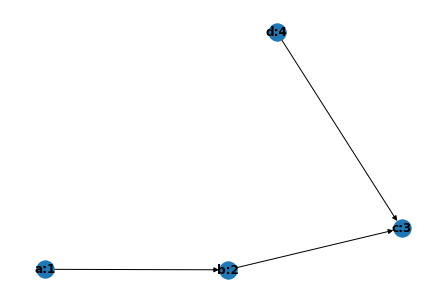

In [81]:
draw_from_vertex(template_vertices[0])

## Extend template with data

In [82]:
class TemplateVertex:
    def __init__(self, name):
        self.name = name
        self.children = []
        self.parents = []
        self.data_vertex = None
    def __repr__(self):
        return f"TemplateVertex({self.name}, {self.data_vertex})"    

In [83]:
class DataVertex:
    def __init__(self, name, identifier):
        self.name = name
        self.identifier = identifier
        self.children = []
        self.parents = []
    def __repr__(self):
        return f"DataVertex({self.name}, {self.identifier})"    

In [84]:
def build_vertex_name_to_vertex_lookup(data_vertex):
    """Build a lookup of vertex name to data vertex object."""
    
    # Precondition
    assert isinstance(data_vertex, DataVertex)
    
    vertex_name_to_vertex = {}
    explored = set()
    
    q = deque()
    q.append(data_vertex)
    
    while len(q) > 0:
        
        vertex = q.popleft()
        explored.add(vertex)
        print(f"Processing {vertex}")
        
        if not vertex.name in vertex_name_to_vertex:
            vertex_name_to_vertex[vertex.name] = [vertex]
        else:
            vertex_name_to_vertex[vertex.name].append(vertex)
        
        for p in vertex.parents:
            if not p in explored:
                q.append(p)
                explored.add(p)
                
        for c in vertex.children:
            if not c in explored:
                q.append(c)
                explored.add(c)      
                
    # Postcondition
    assert isinstance(vertex_name_to_vertex, dict)
    assert len(vertex_name_to_vertex) > 0
    assert data_vertex.name in vertex_name_to_vertex
    
    return vertex_name_to_vertex

In [85]:
# Tests
data_edges = """
d:2 -> a:100
d:11 -> a:100
e:1 -> d:2
f:3 -> d:2
e:10 -> d:11
f:12 -> d:11
"""

data_vertices = build_data_graph(data_edges)
print(data_vertices)
build_vertex_name_to_vertex_lookup(data_vertices[0])

[DataVertex(d, 2), DataVertex(a, 100), DataVertex(d, 11), DataVertex(e, 1), DataVertex(f, 3), DataVertex(e, 10), DataVertex(f, 12)]
Processing DataVertex(d, 2)
Processing DataVertex(e, 1)
Processing DataVertex(f, 3)
Processing DataVertex(a, 100)
Processing DataVertex(d, 11)
Processing DataVertex(e, 10)
Processing DataVertex(f, 12)


{'d': [DataVertex(d, 2), DataVertex(d, 11)],
 'e': [DataVertex(e, 1), DataVertex(e, 10)],
 'f': [DataVertex(f, 3), DataVertex(f, 12)],
 'a': [DataVertex(a, 100)]}

In [86]:
def data_vertices_associated_with_children(template_vertex):
    """Returns the data vertices associated with the children of a template vertex"""
    
    # Precondition
    assert isinstance(template_vertex, TemplateVertex)
    
    data_vertices = []
    
    for child in template_vertex.children:
        if child.data_vertex is not None:
            assert isinstance(child.data_vertex, DataVertex)
            data_vertices.append(child.data_vertex)
    
    # Postcondition
    assert isinstance(data_vertices, list)
    
    return data_vertices

In [87]:
def template_has_child_with_name(template_vertex, name):
    """Does the template vertex have a child with the specified name?"""
    
    # Preconditions
    assert isinstance(template_vertex, TemplateVertex)
    assert isinstance(name, str)
    
    if len(template_vertex.children) == 0:
        return False
    
    for c in template_vertex.children:
        if c.name == name:
            return True
    
    return False

In [88]:
def consistent_children(template_vertex, data_vertex):
    """Does the template vertex and data vertex have consistent children?"""
    
    # Preconditions
    assert isinstance(template_vertex, TemplateVertex)
    assert isinstance(data_vertex, DataVertex)
    
    for child in data_vertex.children:
        if not template_has_child_with_name(template_vertex, child.name):
            return False
        
    return True

In [89]:
def data_vertex_consistent_with_children(template_vertex, child_data_vertices):
    """Returns data vertices that are consistent with the template vertex."""
    
    # Preconditions
    assert isinstance(template_vertex, TemplateVertex)
    assert isinstance(child_data_vertices, list)
    assert len(child_data_vertices) > 0
    
    # Set of potential data vertices that match the template vertex
    potential = set()
    
    for child in child_data_vertices:
        assert isinstance(child, DataVertex), f"Expected a DataVertex, got {type(child)}"
        
        print(child.parents)
        
        for parent in child.parents:
            assert isinstance(parent, DataVertex), f"Expected a DataVertex, got {type(parent)}"
            
            print(f"      Child: {child}, Parent: {parent}")
            
            if parent.name == template_vertex.name:
                potential.add(parent)
                print(f"      Added to potential")
    
    if len(potential) == 0:
        return [], ""
    
    print(f"  POTENTIAL: {potential}")
    
    # Make sure that the potential data vertices only have children that the template
    # vertex has
    for p in potential:
        assert isinstance(p, DataVertex), f"Expected a DataVertex, got {type(p)}"
        
        if not consistent_children(template_vertex, p):
            return [], f"{p} has inconsistent child vertex"
        
    consistent_vertices = list(potential)
        
    # Postcondition
    assert isinstance(consistent_vertices, list)
    for m in consistent_vertices:
        assert isinstance(m, DataVertex), f"Expected a DataVertex, got {type(m)}"
        assert m.name == template_vertex.name, f"Got matched name {m.name}, expected {template_vertex.name}"    
    
    return consistent_vertices, ""

In [90]:
def data_vertex_matches(template_vertex, data_vertex_lookup):
    """Find the data vertex or vertices that match the template."""
    
    # Preconditions
    assert isinstance(template_vertex, TemplateVertex)
    assert isinstance(data_vertex_lookup, dict)
    
    if len(template_vertex.children) == 0:
        # If the template vertex is a leaf vertex, just look for a data vertex with
        # the same name as the template vertex
        matched = data_vertex_lookup.get(template_vertex.name, [])
    
    else:
        # Get a list of the data vertices associated with the children of the template vertex
        ds = data_vertices_associated_with_children(template_vertex)
        print(f"-- Child data vertices of template: {ds}")
        assert isinstance(ds, list)
        
        if len(ds) == 0:
            print("-- No matches")
            # If there are no data vertices amongst the template's child vertices
            # then look for a data vertex with the required name
            matched = data_vertex_lookup.get(template_vertex.name, [])
        
        else:
            print(f"-- {len(ds)} child/ren matches")
            matched, msg = data_vertex_consistent_with_children(template_vertex, ds)
            print(f"-- Data vertices consistent: {matched}")
            
            # If a data vertex has an inconsistent child vertex, return an error
            if msg != "":
                return [], msg
        
            if len(matched) == 0:
                matched = data_vertex_lookup.get(template_vertex.name, [])
        
    # Postcondition
    assert isinstance(matched, list)
    
    for m in matched:
        assert isinstance(m, DataVertex), f"Expected a DataVertex, got {type(v)}"
        assert m.name == template_vertex.name, f"Got matched name {m.name}, expected {template_vertex.name}"
    
    return matched, ""

In [91]:
def match_data_to_template(template_vertex, data_vertex):
    
    # Preconditions
    assert isinstance(template_vertex, TemplateVertex)
    assert isinstance(data_vertex, DataVertex)
    
    # Find the leaf vertices of the template graph
    template_leaf_vertices = find_leaf_vertices(template_vertex)
    assert len(template_leaf_vertices) > 0
    
    # Add each of the template's leaves to the queue to process
    q = deque()
    for t in template_leaf_vertices:
        q.append(t)
        
    # Build the lookup of data vertex name to data vertex object
    data_vertex_lookup = build_vertex_name_to_vertex_lookup(data_vertex)
    print(data_vertex_lookup)
    assert len(data_vertex_lookup) > 0
    
    while len(q) > 0:
        
        # Take a template vertex off the queue
        template_vertex = q.popleft()
        print(f"Processing {template_vertex}")
        
        # Process the template vertex
        matched, msg = data_vertex_matches(template_vertex, data_vertex_lookup)
        assert msg == ""
        
        if len(matched) == 0:
            pass
        elif len(matched) == 1:
            print(f"  Assigning {matched[0]} to {template_vertex}")
            template_vertex.data_vertex = matched[0]
        else:
            assert False
        
        # Add all of the template vertex's parents to the queue to process
        for p in template_vertex.parents:
            q.append(p)

In [92]:
template_edges = """
a -> b
b -> c
d -> c
"""

data_edges = """
b:2 -> c:3
d:4 -> c:3
"""

template_vertices = build_template_graph(template_edges)
data_vertices = build_data_graph(data_edges)

In [93]:
template_vertex = template_vertices[0]
data_vertex = data_vertices[0]

match_data_to_template(template_vertex, data_vertex)

Processing DataVertex(b, 2)
Processing DataVertex(c, 3)
Processing DataVertex(d, 4)
{'b': [DataVertex(b, 2)], 'c': [DataVertex(c, 3)], 'd': [DataVertex(d, 4)]}
Processing TemplateVertex(c, None)
  Assigning DataVertex(c, 3) to TemplateVertex(c, None)
Processing TemplateVertex(b, None)
-- Child data vertices of template: [DataVertex(c, 3)]
-- 1 child/ren matches
[DataVertex(b, 2), DataVertex(d, 4)]
      Child: DataVertex(c, 3), Parent: DataVertex(b, 2)
      Added to potential
      Child: DataVertex(c, 3), Parent: DataVertex(d, 4)
  POTENTIAL: {DataVertex(b, 2)}
-- Data vertices consistent: [DataVertex(b, 2)]
  Assigning DataVertex(b, 2) to TemplateVertex(b, None)
Processing TemplateVertex(d, None)
-- Child data vertices of template: [DataVertex(c, 3)]
-- 1 child/ren matches
[DataVertex(b, 2), DataVertex(d, 4)]
      Child: DataVertex(c, 3), Parent: DataVertex(b, 2)
      Child: DataVertex(c, 3), Parent: DataVertex(d, 4)
      Added to potential
  POTENTIAL: {DataVertex(d, 4)}
-- Data

In [94]:
template_vertices

[TemplateVertex(a, None),
 TemplateVertex(b, DataVertex(b, 2)),
 TemplateVertex(c, DataVertex(c, 3)),
 TemplateVertex(d, DataVertex(d, 4))]

### Functionality to handle replicas

In [95]:
def copy_graph(initial_vertex):
    """Make an exact copy of the entire of a graph."""
    
    # Preconditions
    assert isinstance(initial_vertex, TemplateVertex)
    
    initial_vertex_name = initial_vertex.name
    
    # Set of explored vertices
    explored = set()

    q = deque()
    q.append(initial_vertex)
    
    # Dict of a new vertex's name to the vertex object
    new_vertex_name_to_vertex = {}
    
    # Make all of the new (unconnected) vertices
    while len(q) > 0:
        
        # Take a vertex from the queue
        vertex = q.popleft()
    
        explored.add(vertex.name)
        print(f"Processing {vertex}")
        
        new_vertex = TemplateVertex(vertex.name)
        print(f"Created {new_vertex}")
        new_vertex_name_to_vertex[vertex.name] = new_vertex

        for parent in vertex.parents:
            if not parent.name in explored:
                parent.explored = True
                q.append(parent)
        
        for child in vertex.children:
            if not child.name in explored:
                child.explored = True
                q.append(child)
    
    # Now connect up the vertices
    explored = set()
    
    q = deque()
    q.append(initial_vertex)
    
    while len(q) > 0:
        
        # Take a vertex from the queue
        vertex = q.popleft()
    
        explored.add(vertex.name)
        print(f"Processing {vertex} to connect it up")
        
        for parent in vertex.parents:
            if not parent.name in explored:
                parent.explored = True
                
                p = new_vertex_name_to_vertex[parent.name]
                v = new_vertex_name_to_vertex[vertex.name]
                v.parents.append(p)
                p.children.append(v)
                
                q.append(parent)
        
        for child in vertex.children:
            if not child.name in explored:
                child.explored = True
                
                c = new_vertex_name_to_vertex[child.name]
                v = new_vertex_name_to_vertex[vertex.name]
                v.children.append(c)
                c.parents.append(v)
                
                q.append(child)        
    
    return new_vertex_name_to_vertex[initial_vertex_name]

In [96]:
def replicate_subgraph(vertex, n_replicas):
        
    # Preconditions
    assert isinstance(vertex, TemplateVertex)
    assert n_replicas > 1
    
    copies = []
    for i in range(n_replicas):
        
        # Copy the subgraph
        copy = copy_graph(vertex)

        # Find the leaf vertex of the copied subgraph
        copy_leaves = find_leaf_vertices(copy)
        assert len(copy_leaves) == 1
        copies.append(copy_leaves[0])
    
    # Postconditions
    assert len(copies) == n_replicas
    for c in copies:
        assert isinstance(c, TemplateVertex), f"Expected a TemplateVertex, got {type(c)}"
        
    return copies

In [97]:
def disconnect_subgraph(template_vertex):

    # Preconditions
    assert isinstance(template_vertex, TemplateVertex)
    assert len(template_vertex.children) > 0
    
    # Make a copy of the children of the vertex to disconnect
    disconnected_vertex_children = template_vertex.children[:]
    
    # Disconnect the children of the template vertex
    template_vertex.children = []
    
    # Remove the template vertex as a parent of the vertex's children
    for c in disconnected_vertex_children:
        assert template_vertex in c.parents
        c.parents.remove(template_vertex)
    
    return template_vertex, disconnected_vertex_children

In [98]:
def perform_replication_of_subgraph(template_vertex, data_vertices, aggregation_vertex_builder):
    """Replicate the subgraph below the template vertex."""
    
    # Preconditions
    assert isinstance(template_vertex, TemplateVertex)
    assert isinstance(data_vertices, list)
    assert len(data_vertices) > 1
    for d in data_vertices:
        assert isinstance(d, DataVertex)
    
    # 1. Disconnect the vertex (and its subgraph) that needs replicating from the graph
    disconnected_vertex, disconnected_vertex_children = disconnect_subgraph(template_vertex)
    assert len(disconnected_vertex_children) > 0
    assert disconnected_vertex.children == []
    for c in disconnected_vertex_children:
        assert template_vertex not in c.parents
    
    # 2. Replicate the disconnected subgraph the required number of times
    number_of_replicas = len(data_vertices)
    assert number_of_replicas > 1
    
    replicas = replicate_subgraph(template_vertex, number_of_replicas)
    assert isinstance(replicas, list)
    assert len(replicas) == number_of_replicas
    for r in replicas:
        assert isinstance(r, TemplateVertex)
    
    # 3. Assign the data vertices to the replicas
    for idx in range(number_of_replicas):
        replicas[idx].data_vertex = data_vertices[idx]
        
    # 4. Use the aggregation vertex builder function to make a new vertex
    aggregation_vertex = aggregation_vertex_builder(number_of_replicas) 
    assert isinstance(aggregation_vertex, TemplateVertex)
    assert len(aggregation_vertex.children) == 0
    assert len(aggregation_vertex.parents) == 0
    
    # 5. Connect the replicas to the aggregation vertex
    for r in replicas:
        r.children.append(aggregation_vertex)
        aggregation_vertex.parents.append(r)
    
    # 6. Connect the aggregation vertex to the children of the disconnected vertex
    for child in disconnected_vertex_children:
        assert isinstance(child, TemplateVertex)
        assert template_vertex not in child.parents
        aggregation_vertex.children.append(child)
        child.parents.append(aggregation_vertex)
    
    return aggregation_vertex

In [99]:
# Tests
template_edges = """
b -> a
c -> a
d -> a
e -> d
f -> d
"""

data_edges = """
e:1 -> d:2
f:3 -> d:2
e:10 -> d:11
f:12 -> d:11
"""

template_vertices = build_template_graph(template_edges)
print(template_vertices)

data_vertices = build_data_graph(data_edges)
print(data_vertices)

template_vertex = template_vertices[3]
assert template_vertex.name == "d"

data_vertices_for_d = [data_vertices[1], data_vertices[4]]
assert data_vertices_for_d[0].name == "d"
assert data_vertices_for_d[1].name == "d"

aggregation_vertex_builder = lambda x: TemplateVertex(f"AGG-{x}")

perform_replication_of_subgraph(template_vertex, data_vertices_for_d, aggregation_vertex_builder)

[TemplateVertex(b, None), TemplateVertex(a, None), TemplateVertex(c, None), TemplateVertex(d, None), TemplateVertex(e, None), TemplateVertex(f, None)]
[DataVertex(e, 1), DataVertex(d, 2), DataVertex(f, 3), DataVertex(e, 10), DataVertex(d, 11), DataVertex(f, 12)]
Processing TemplateVertex(d, None)
Created TemplateVertex(d, None)
Processing TemplateVertex(e, None)
Created TemplateVertex(e, None)
Processing TemplateVertex(f, None)
Created TemplateVertex(f, None)
Processing TemplateVertex(d, None) to connect it up
Processing TemplateVertex(e, None) to connect it up
Processing TemplateVertex(f, None) to connect it up
Processing TemplateVertex(d, None)
Created TemplateVertex(d, None)
Processing TemplateVertex(e, None)
Created TemplateVertex(e, None)
Processing TemplateVertex(f, None)
Created TemplateVertex(f, None)
Processing TemplateVertex(d, None) to connect it up
Processing TemplateVertex(e, None) to connect it up
Processing TemplateVertex(f, None) to connect it up


TemplateVertex(AGG-2, None)

In [109]:
def match_data_to_template(template_vertex, data_vertex):
    
    # Preconditions
    assert isinstance(template_vertex, TemplateVertex)
    assert isinstance(data_vertex, DataVertex)
    
    # Find the leaf vertices of the template graph
    template_leaf_vertices = find_leaf_vertices(template_vertex)
    assert len(template_leaf_vertices) > 0
    
    # Add each of the template's leaves to the queue to process
    q = deque()
    for t in template_leaf_vertices:
        q.append(t)
        
    # Build the lookup of data vertex name to data vertex object
    data_vertex_lookup = build_vertex_name_to_vertex_lookup(data_vertex)
    print(data_vertex_lookup)
    assert len(data_vertex_lookup) > 0
    
    while len(q) > 0:
        
        # Take a template vertex off the queue
        template_vertex = q.popleft()
        print("------")
        print(f"Processing {template_vertex}")
        
        # Process the template vertex
        matched, msg = data_vertex_matches(template_vertex, data_vertex_lookup)
        assert msg == ""
        assert isinstance(matched, list)
        for m in matched:
            assert isinstance(m, DataVertex), f"Expected a DataVertex, got {type(v)}"
            assert m.name == template_vertex.name, f"Got matched name {m.name}, expected {template_vertex.name}"        
        
        if len(matched) == 0:
            print(f"  No match for {template_vertex}")
            
            # Add all of the template vertex's parents to the queue to process
            for p in template_vertex.parents:
                q.append(p)            
            
        elif len(matched) == 1:
            print(f"  Assigning {matched[0]} to {template_vertex}")
            template_vertex.data_vertex = matched[0]
            
            # Add all of the template vertex's parents to the queue to process
            for p in template_vertex.parents:
                q.append(p)
            
        else:
            print(f"  Replication of {template_vertex} {len(matched)} times")
            aggregation_vertex_builder = lambda x: TemplateVertex(f"AGG-{x}")
            aggregation_vertex = perform_replication_of_subgraph(template_vertex, matched, aggregation_vertex_builder)
            print("****", aggregation_vertex)
        
            for p in aggregation_vertex.parents:
                for p2 in p.parents:
                    q.append(p2)

In [117]:
# Tests
template_edges = """
b -> a
c -> a
d -> a
e -> d
f -> d
"""

data_edges = """
d:2 -> a:100
d:11 -> a:100
e:1 -> d:2
f:3 -> d:2
e:10 -> d:11
f:12 -> d:11
"""

template_vertices = build_template_graph(template_edges)
print(template_vertices)

data_vertices = build_data_graph(data_edges)
print(data_vertices)

match_data_to_template(template_vertices[0], data_vertices[0])

[TemplateVertex(b, None), TemplateVertex(a, None), TemplateVertex(c, None), TemplateVertex(d, None), TemplateVertex(e, None), TemplateVertex(f, None)]
[DataVertex(d, 2), DataVertex(a, 100), DataVertex(d, 11), DataVertex(e, 1), DataVertex(f, 3), DataVertex(e, 10), DataVertex(f, 12)]
Processing DataVertex(d, 2)
Processing DataVertex(e, 1)
Processing DataVertex(f, 3)
Processing DataVertex(a, 100)
Processing DataVertex(d, 11)
Processing DataVertex(e, 10)
Processing DataVertex(f, 12)
{'d': [DataVertex(d, 2), DataVertex(d, 11)], 'e': [DataVertex(e, 1), DataVertex(e, 10)], 'f': [DataVertex(f, 3), DataVertex(f, 12)], 'a': [DataVertex(a, 100)]}
------
Processing TemplateVertex(a, None)
  Assigning DataVertex(a, 100) to TemplateVertex(a, None)
------
Processing TemplateVertex(b, None)
-- Child data vertices of template: [DataVertex(a, 100)]
-- 1 child/ren matches
[DataVertex(d, 2), DataVertex(d, 11)]
      Child: DataVertex(a, 100), Parent: DataVertex(d, 2)
      Child: DataVertex(a, 100), Paren

In [118]:
def draw_graph(vertex):
    """Draw the graph from any template vertex."""
    
    # Preconditions
    assert isinstance(vertex, TemplateVertex) or isinstance(vertex, DataVertex)
    
    G = nx.DiGraph()
    explored = set()
    
    q = deque()
    q.append(vertex)
    
    def make_label(vertex):
        if isinstance(vertex, TemplateVertex):
        
            label = f"{vertex.name}"

            if vertex.data_vertex is not None:
                label += f"/{vertex.data_vertex.name}:{vertex.data_vertex.identifier}"

            assert type(label) == str
            return label
        
        elif isinstance(vertex, DataVertex):
            return f"{vertex.name}:{vertex.identifier}"
        else:
            assert False
    
    while len(q) > 0:
        
        # Take a vertex off the queue
        vertex = q.popleft()
        
        # Record that the vertex has been explored
        explored.add(vertex)
        
        if len(vertex.parents) == 0 and len(vertex.children) == 0:
            G.add_node(make_label(vertex))
    
        for p in vertex.parents:
            if not p in explored:
                explored.add(p)
                q.append(p)
                
                src = make_label(p)
                dst = make_label(vertex)
                G.add_edge(src, dst)
                
        
        for c in vertex.children:
            if not c in explored:
                explored.add(c)
                q.append(c)
                
                src = make_label(vertex)
                dst = make_label(c)                
                G.add_edge(src, dst)
    
    # Draw the graph
    nx.draw(G, with_labels=True, font_weight='bold')  

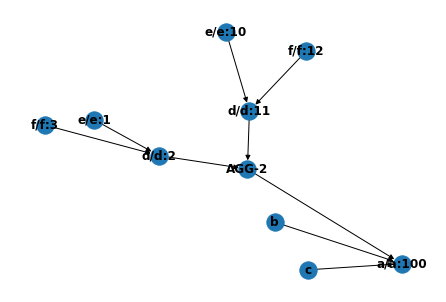

In [120]:
draw_graph(template_vertices[0])

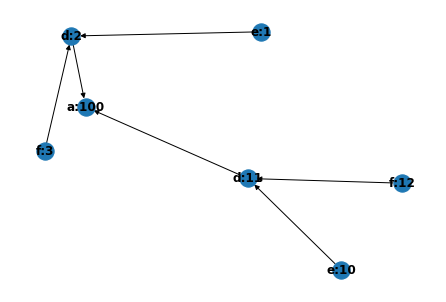

In [121]:
draw_graph(data_vertices[0])

In [116]:
data_vertices

[DataVertex(e, 1),
 DataVertex(d, 2),
 DataVertex(f, 3),
 DataVertex(e, 10),
 DataVertex(d, 11),
 DataVertex(f, 12)]